# Vorhersage der Spielfeldposition bei Fußballspielern

*von Alexander Piglmann, Alexander Roucka, Andrei Dragoi, Beatrice Steiner, Fabian Fiedler*

## Imports & Einstellungen

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import zscore
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV as CV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

from bdsm.metrics import confusion_matrix
from bdsm import quality

Anzeigeeinstellungen des Outputs anpassen

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 10) # 10
pd.set_option('display.max_columns', 20) # 20
pd.set_option('display.width', 80) # 80
pd.set_option('display.max_colwidth', 50) # 50

color = 'rocket' #globale Farbpalette für die Visualisierungen

## Einlesen der Daten

In [3]:
fifa_1 = pd.read_csv('fifa.csv', delimiter = ',')
fifa_2 = pd.read_csv('fifa_countries.csv', encoding = 'utf-8', delimiter = ';')

Umbennenung der Spalte Club, um die Datensätze später zusammenführen zu können

In [4]:
fifa_1.rename({'Club':'Clubname'}, axis=1, inplace=True)

Zusammenführung der Daten

In [5]:
fifa = fifa_1.merge(fifa_2, on='Clubname')
fifa.columns

Index(['Row', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Clubname', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTack

In [6]:
quality(fifa).T


Dataframe has 17,938 rows and 90 columns.

75 columns have missing values.


,Row,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Clubname,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Country
type,int64,int64,object,int64,object,object,object,int64,int64,object,...,float64,float64,float64,float64,float64,float64,float64,float64,object,object
unique,17938,17938,16940,29,17938,163,163,48,47,650,...,92,90,88,71,70,79,79,76,1241,36
missing_abs,0,0,0,0,0,0,0,0,0,0,...,48,48,48,48,48,48,48,48,1322,0
missing_rel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.27,0.27,0.27,0.27,0.27,0.27,0.27,0.27,7.37,0.0


## What to do?

  **-> Kann man von den Stats die Position predicten (Stürmer, Verteidiger, Mittelfeld, Tormann[evtl weg])? mit Sample**
  - **Photo, Flag, ID, Name, Row, Club Logo, Real Face, Country, Clubname, Joined, Loaned From droppen**
  - **VIF-Werte ansehen & bereinigen**
  - **möglich wären je nach gwähltem input: Decision Tree, logistische Regression (wobei eher schlecht weil viele Klassen), Random Forest, SVC, kNN**

  -> Kann man mit den Daten das Alter predicten? 3. Platz
  - Photo, Flag, ID, Name, Row, Club Logo, Real Face, Country, Clubname, Loaned From, Joined droppen
  - VIF-Werte ansehen & bereinigen
  - kategoriale Daten encoden & Regression machen = Multiple Regression, Decision Tree Regression, SVR

  -> Kann man das Gehalt predicten? 2. Platz
  - Photo, Flag, ID, Name, Row, Club Logo, Real Face, Country, Joined droppen
  - VIF-Werte ansehen & bereinigen
  - kategoriale Daten encoden & Regression machen = Multiple Regression, Decision Tree Regression, SVR



  -> Kann man den Club vorhersagen?
  - Photo, Flag, ID, Name, Row, Club Logo, Real Face, Country, Clubname, Joined, Loaned From droppen
  - VIF-Werte ansehen & bereinigen
  - möglich wären je nach gwähltem input: Decision Tree, logistische Regression (wobei eher schlecht weil viele Klassen), Random Forest, SVC, kNN


## Datenbereinigung

In [7]:
# drops = list(quality(fifa)[quality(fifa)['missing_rel'] >= 10].reset_index().iloc[:,0]) # um alle Dimensionen mit 10 % MV entfernen

Bereinigung der Spieler, welche keine Positionswertungen enthalten.

In [8]:
df = fifa.dropna(axis = 0, subset=['LS']) # Keine eckigen Klammern, da ja schon liste

Zusammenfassen der einzelnen Spielpositionen zu den Labels Tormann, Stürmer, Mittelfeld und Verteidiger

In [9]:
Tormann = ['GK']
Stuermer = ['CF','RF', 'LF', 'ST', 'RS', 'LS', 'RW', 'LW', 'CF']
Mittelfeld = ['CDM', 'RCM', 'CAM', 'LCM', 'CM', 'LM', 'RAM', 'RM', 'LDM', 'RDM', 'LAM']
Verteidiger = ['CB', 'LB', 'RB', 'LCB', 'RWB', 'LWB', 'RCB']

df['label'] = np.where(df['Position'].isin(Tormann), 'Tormann', 'invalid')
df['label'] = np.where(df['Position'].isin(Stuermer), 'Stuermer', df['label'])
df['label'] = np.where(df['Position'].isin(Mittelfeld), 'Mittelfeld', df['label'])
df['label'] = np.where(df['Position'].isin(Verteidiger), 'Verteidiger', df['label'])

Überprüfung der Daten & herauslöschen der Positionsspalte

In [10]:
df = df[df['label'] != 'invalid']
df = df.drop(columns='Position')
df['label'].unique()

array(['Stuermer', 'Mittelfeld', 'Verteidiger'], dtype=object)

Durch die dropna-Funktion haben wir die Torwäte verloren, wir haben beschlossen die leeren Werte
nicht durch 0 zu ersetzen, da das Modell sich dann evtl nicht mehr so auf die anderen Werte konzentriert.

**Als nächstes droppen wir Spalten, welche für unser Klassifikationsproblem irrelevant sind.**

1) Photo, Flag, Club Logo - nichtsaussagende Daten für unsere Klassifikation (Links)
2) GKDiving, GKHandling, GKKicking, GKPositioning, GKReflexes: Da wir keine Goalkeeper haben nehmen wir diese Dimensionen heraus
3) Da sklearn keine NaN-Values mag, mussten wir die Spalten Release Clause, Joined und Loaned From entfernen.
4) Die Daten bei Body-Type waren nicht gut
5) Work Rate, Real Face hatten keine Aussagekraft
6) Name, Row, ID, Country, Clubname spielen für uns keine Rolle

In [11]:
drops = ['Photo', 'Flag', 'Club Logo', 'Work Rate', 'Real Face', 'Joined',
        'Loaned From', 'Jersey Number', 'Row', 'ID', 'Clubname', 'Country', 
        'Body Type', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning',
        'GKReflexes', 'Name', 'Release Clause']
df.drop(columns=drops, inplace=True)

### Bereinigung von numerischen Spalten

#### Bereinigung von Geldbeträgen
Hierfür wurde eine eigene Funktion, welche die Daten reinigt und in die korrekte Ganzzahl umwandelt geschrieben

In [12]:
def convert(x):
    if 'M' in str(x):
        return float(x.split('€')[1].split('M')[0])*1000000 
    elif 'K' in str(x):
        return float(x.split('€')[1].split('K')[0])*1000 
    elif '€' in str(x):
        return float(x.split('€')[1])
    else:
        return x

In [13]:
# df['Release Clause_num'] = df['Release Clause'].apply(convert)
# df['Release Clause_num']

In [14]:
df['Wage_num'] = df['Wage'].apply(convert)
df['Wage_num']

0        565000.0
1        455000.0
3        315000.0
4        340000.0
5        205000.0
           ...   
17932      1000.0
17933      1000.0
17934      1000.0
17936      1000.0
17937      1000.0
Name: Wage_num, Length: 15901, dtype: float64

In [15]:
df['Value_num'] = df['Value'].apply(convert)
df['Value_num']

0        110500000.0
1         80000000.0
3         51500000.0
4         69500000.0
5         57000000.0
            ...     
17932        70000.0
17933        60000.0
17934        50000.0
17936        60000.0
17937        50000.0
Name: Value_num, Length: 15901, dtype: float64

#### Bereinigung des Gewichts
Hier werden Pfund in Kilogramm umgerechnet und die Einheit entfernt.

In [16]:
df['Weight_kg'] = df['Weight'].apply(lambda x: round(float(x.split('lbs')[0])*0.45359237, 2))
df['Weight_kg']

0        72.12
1        86.18
3        76.20
4        68.04
5        74.84
         ...  
17932    74.84
17933    73.03
17934    82.10
17936    66.22
17937    60.78
Name: Weight_kg, Length: 15901, dtype: float64

#### Bereinigung der Größe
Die Größe wird vom imperialten ins das metrische System umgewandelt.

In [17]:
df['Height_cm'] = df['Height'].apply(lambda x: float(x.split("'")[0])*30.48+float(x.split("'")[1])*2.54)
df['Height_cm']

0        170.18
1        182.88
3        187.96
4        172.72
5        182.88
          ...  
17932    180.34
17933    175.26
17934    185.42
17936    177.80
17937    180.34
Name: Height_cm, Length: 15901, dtype: float64

Nach dem Umwandeln werden nun die Spalten mit den Altdaten verworfen.

In [18]:
drops_2 = ['Value', 'Wage', 'Weight', 'Height'] 
df.drop(columns=drops_2, axis=1, inplace=True)

#### Bereinigung von Zusätzen bei dem Spalten der Wertungen nach Spielfeldposition.

Das Problem hierbei war, dass an alle Werte '+2' angehängt war.

In [19]:
col = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

In [20]:
for i in col:
    df[i] = df[i].apply(lambda x: int(x.split('+')[0]) if '+' in x else int(x))
df.head()

,Age,Nationality,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Contract Valid Until,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,label,Wage_num,Value_num,Weight_kg,Height_cm
0,31,Argentina,94,94,2202,Left,5.0,4.0,4.0,2021,...,75.0,96.0,33.0,28.0,26.0,Stuermer,565000.0,110500000.0,72.12,170.18
1,31,Uruguay,91,91,2346,Right,5.0,4.0,3.0,2021,...,85.0,85.0,62.0,45.0,38.0,Stuermer,455000.0,80000000.0,86.18,182.88
3,29,Spain,89,89,2065,Right,4.0,3.0,3.0,2023,...,60.0,90.0,90.0,86.0,80.0,Mittelfeld,315000.0,51500000.0,76.20,187.96
4,26,Brazil,88,89,2175,Right,3.0,4.0,5.0,2023,...,70.0,85.0,55.0,54.0,47.0,Stuermer,340000.0,69500000.0,68.04,172.72
5,24,France,87,92,2147,Left,3.0,3.0,2.0,2023,...,61.0,82.0,90.0,89.0,86.0,Verteidiger,205000.0,57000000.0,74.84,182.88


#### Umwandlung von 'Contract Valid Until'
Nun entfernen wir noch überflüssige Informationen aus der Spalte Contract Valid Until und nehmen nur das Jahr als mit.

In [21]:
df['Contract Valid Until'] = df['Contract Valid Until'].apply(lambda x: pd.to_datetime(x).year)


In [22]:
quality(df).T

Dataframe has 15,901 rows and 70 columns.

0 columns have missing values.


,Age,Nationality,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Contract Valid Until,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,label,Wage_num,Value_num,Weight_kg,Height_cm
type,int64,object,int64,int64,int64,object,float64,float64,float64,int64,...,float64,float64,float64,float64,float64,object,float64,float64,float64,float64
unique,26,162,48,46,1037,2,5,5,4,9,...,81,68,85,84,82,3,143,211,53,20
missing_abs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_rel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Überlegungen weiterer Bereinigungen

**Ergebnisse der Metadatenrecherche:**

- Crossing (Flanken)
- Skill Moves: sind Daten für das FIFA-Spiel (1-5)
- Finishing (Torschussfähigkeitsbewertung)
- Volley (Ballannahme in der Luft)
- Curve ("Banane schießen", Effet-Schuss)
- FKAccuracy (Freischusspräzesion)
- Interceptions (Abfangfähigkeit)
- Vision (Weitblick)
- Marking (Manndeckung)
- StandingTackle (Ballabnahme o. Grätsche)


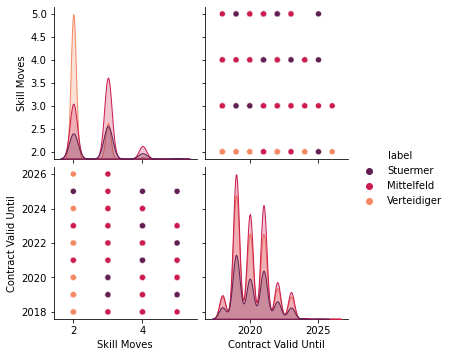

In [23]:
sns.pairplot(df[['Skill Moves', 'Contract Valid Until', 'label']], hue='label', palette=color)

Skill Moves scheint gut geeignet zu sein, bei der Klassifizierung der Verteidiger zu helfen.

Contract Valid Until wird entfernt, da es keinen Mehrwert zu bieten scheint.

In [24]:
df.drop(['Contract Valid Until'], axis=1, inplace=True)

## Datenaufbereitung für die Modelle
modelspezifische Vorverarbeitung werden bei der Modellerstellung ergänzt

In [25]:
quality(df).T

Dataframe has 15,901 rows and 69 columns.

0 columns have missing values.


,Age,Nationality,Overall,Potential,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,LS,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,label,Wage_num,Value_num,Weight_kg,Height_cm
type,int64,object,int64,int64,int64,object,float64,float64,float64,int64,...,float64,float64,float64,float64,float64,object,float64,float64,float64,float64
unique,26,162,48,46,1037,2,5,5,4,59,...,81,68,85,84,82,3,143,211,53,20
missing_abs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_rel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Encoding der kategorialen Dimensionen

In [26]:
# Preferred Foot
df['Preferred Foot'] = df['Preferred Foot'].astype('category')
df['Preferred Foot_cat'] = df['Preferred Foot'].cat.codes


In [27]:
# Nationality
df['Nationality'] = df['Nationality'].astype('category')
df['Nationality_cat'] = df['Nationality'].cat.codes
df['label'].value_counts()

Mittelfeld     6752
Verteidiger    5771
Stuermer       3378
Name: label, dtype: int64

In [28]:
# label
df['label'] = df['label'].astype('category')
df['label_cat'] = df['label'].cat.codes
df.drop(['Preferred Foot', 'Nationality', 'label'], axis=1, inplace=True)
df['label_cat'].value_counts()

0    6752
2    5771
1    3378
Name: label_cat, dtype: int64

## Diskussion des Modells

**Klassifikationsproblem, daher folgende Modelle möglich:**

 **Decision Tree**
- NULL-Wertentfernung erforderlich: nein
- VIF: nein
- Standardisierung: nein, Interpretierbarkeit geht dadurch verloren
- LDA/PCA: nein
- Kategoriale UV Werte erlaubt: ja (encoding)
- AV encoden: nein

 **Random Forest (bagging)**
- NULL-Wertentfernung erforderlich: nein
- VIF: nein
- Standardisierung: nein
- LDA/PCA: ja
- Kategoriale UV Werte erlaubt: ja (encoding)
- AV encoden: nein
- Bagging/Pasting:
    - je nach verwendetem Verfahren siehe oben (Anmerkung: bei DecisionTree wie bei Random Forest vorgehen (Interpretierbarkeit fällt weg))
- Out-Of-Bag:
    - mit zurücklegen kann man auch noch ein Test-Set erschaffen
    - je nach verwendetem Verfahren siehe oben (Anmerkung: bei DecisionTree wie bei Random Forest vorgehen (Interpretierbarkeit fällt weg))

 **logistische Regression**: 
- NULL-Wertentfernung erforderlich: ja
- VIF: ja
- Standardisierung: nein, da sonst die Interpretierbarkeit verloren geht (bei binär) | mehrere Klassen evtl.
- LDA/PCA: ja, muss man aber nicht
- Kategoriale UV Werte erlaubt: ja (dummy encoding)
- AV encoden: ja

 **kNN**
- NULL-Wertentfernung erforderlich: ja
- VIF: nein, könnte man aber Feature Selection verwenden
- Standardisierung: ja
- LDA/PCA: ja - immer wenn es im Distanzen geht
- Kategoriale UV Werte erlaubt: nein
- AV encoden: ja
- möglichst wenige Dimensionen

 **SVC**
- NULL-Wertentfernung erforderlich: ja
- VIF: nein
- Standardisierung: ja
- LDA/PCA: ja
- bei nicht linearen Trennungen richtigen Kernel wählen (rbf, ..)
- Kategoriale UV Werte erlaubt: ja
- AV encoden: ja

 **Voting Classifier**
- je nach verwendetem Verfahren siehe oben



## Decision Tree classification

Ohne weitere Vorverarbeitung werden definieren wir hier die Trainings- und Testdaten.

In [29]:
X = df.drop("label_cat", axis=1)
y = df["label_cat"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state=147)

Mit der Funktion aus sklearn.model_selection, *'GridSearchCV'*, haben wir hier versucht, die optimalen Parameter zu finden. 

In [30]:
classifier = DecisionTreeClassifier()

parameters = [{'max_depth': [5,8,9,10],
            'min_samples_leaf':[6,7,8,9,10],
            'criterion': ['gini', 'entropie']}]

grid_search = CV(estimator= classifier,
                param_grid= parameters,
                scoring = 'accuracy',
                n_jobs = -1, # verwendet alle CPUS
                cv = 10)

grid_search.fit(X_train,y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f}%".format(best_accuracy*100))
print("Best Parameters:", best_parameters)


Best Accuracy: 82.64%
Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 9}


### Training Decision Tree

In [31]:
model = DecisionTreeClassifier(criterion="gini", random_state=147,max_depth=8, min_samples_leaf=7)   
model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=7, random_state=147)

### Evaluierung Decision Tree

In [32]:
y_pred = model.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

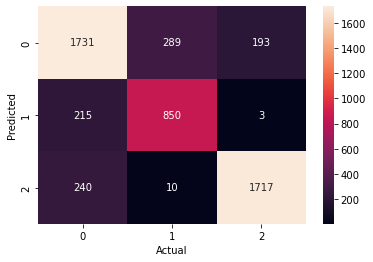

In [33]:
conf_matrix = confusion_matrix(y_pred, y_test)
sns.heatmap(conf_matrix, annot=True, fmt="0", cmap=sns.color_palette(color, as_cmap=True))

**0: Mittelfeld**  
**1: Stuermer**  
**2: Verteidiger**

Hier kann man sehen, dass die Verteidiger besser klassifiziert wurden.

In [34]:
print(f"Cohens_Kappa: {cohen_kappa_score(y_test, y_pred)}")
print(f"{classification_report(y_test, y_pred)}")


Cohens_Kappa: 0.7185484402262339
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      2186
           1       0.80      0.74      0.77      1149
           2       0.87      0.90      0.89      1913

    accuracy                           0.82      5248
   macro avg       0.82      0.81      0.81      5248
weighted avg       0.82      0.82      0.82      5248



## Random Forest (out-of-bag) classification

### Datenaufbereitung Random Forest

In [35]:
rf = df.copy()

In [36]:
X_rf = rf.drop("label_cat", axis=1)
y_rf = rf["label_cat"].copy()
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_rf, y_rf)

In [37]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_lda, y_rf, test_size = 0.33,random_state=147)

Nun wieder die optimalen Parameter herausfinden.

In [38]:
classifier = RandomForestClassifier()

parameters = [{
            'max_depth': [10],
            'min_samples_leaf':[10, 15, 20],
            'criterion': ['gini'],
            'max_leaf_nodes': [10, 20, 50],
            'n_estimators': [100]
            }]

grid_search = CV(estimator= classifier,
                param_grid= parameters,
                scoring = 'accuracy',
                n_jobs = -1, # verwendet alle CPUS
                cv = 6)

grid_search.fit(X_train_rf,y_train_rf)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f}%".format(best_accuracy*100))
print("Best Parameters:", best_parameters) #86,32

Best Accuracy: 86.29%
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'n_estimators': 100}


### Training Random Forest

In [39]:
rf_clf = RandomForestClassifier(
    criterion='gini',
    min_samples_leaf=10,
    n_estimators=100, 
    max_leaf_nodes=10,
    n_jobs=-1,
    max_depth=10,
    oob_score=True
)

In [40]:
rf_clf.fit(X_train_rf, y_train_rf)


RandomForestClassifier(max_depth=10, max_leaf_nodes=10, min_samples_leaf=10,
                       n_jobs=-1, oob_score=True)

### Evaluierung Random Forest

In [41]:
y_pred_rf = rf_clf.predict(X_test_rf)

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

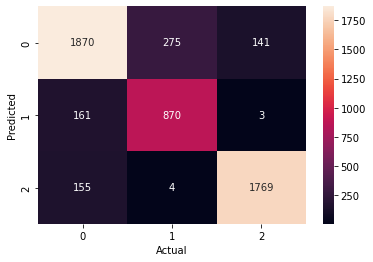

In [42]:
conf_matrix = confusion_matrix(y_pred_rf, y_test_rf)
sns.heatmap(conf_matrix, annot=True, fmt="0", cmap=sns.color_palette(color, as_cmap=True))

**0: Mittelfeld**  
**1: Stuermer**  
**2: Verteidiger**

In [43]:
print(f"Cohens_Kappa: {cohen_kappa_score(y_test_rf, y_pred_rf)}")
print(f"{classification_report(y_test_rf, y_pred_rf)}")
print(f"oob-scrore: {rf_clf.oob_score_}")

Cohens_Kappa: 0.7804914631430943
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2186
           1       0.84      0.76      0.80      1149
           2       0.92      0.92      0.92      1913

    accuracy                           0.86      5248
   macro avg       0.86      0.85      0.85      5248
weighted avg       0.86      0.86      0.86      5248

oob-scrore: 0.8607903876842204


## Logistische Regression in 2 Varianten

In [44]:
lr = df.copy()
quality(lr).T

Dataframe has 15,901 rows and 69 columns.

0 columns have missing values.


,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,LS,ST,RS,...,Marking,StandingTackle,SlidingTackle,Wage_num,Value_num,Weight_kg,Height_cm,Preferred Foot_cat,Nationality_cat,label_cat
type,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,...,float64,float64,float64,float64,float64,float64,float64,int8,int16,int8
unique,26,48,46,1037,5,5,4,59,59,59,...,85,84,82,143,211,53,20,2,162,3
missing_abs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
missing_rel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Variante 1 ohne Multikollinearität

<AxesSubplot:>

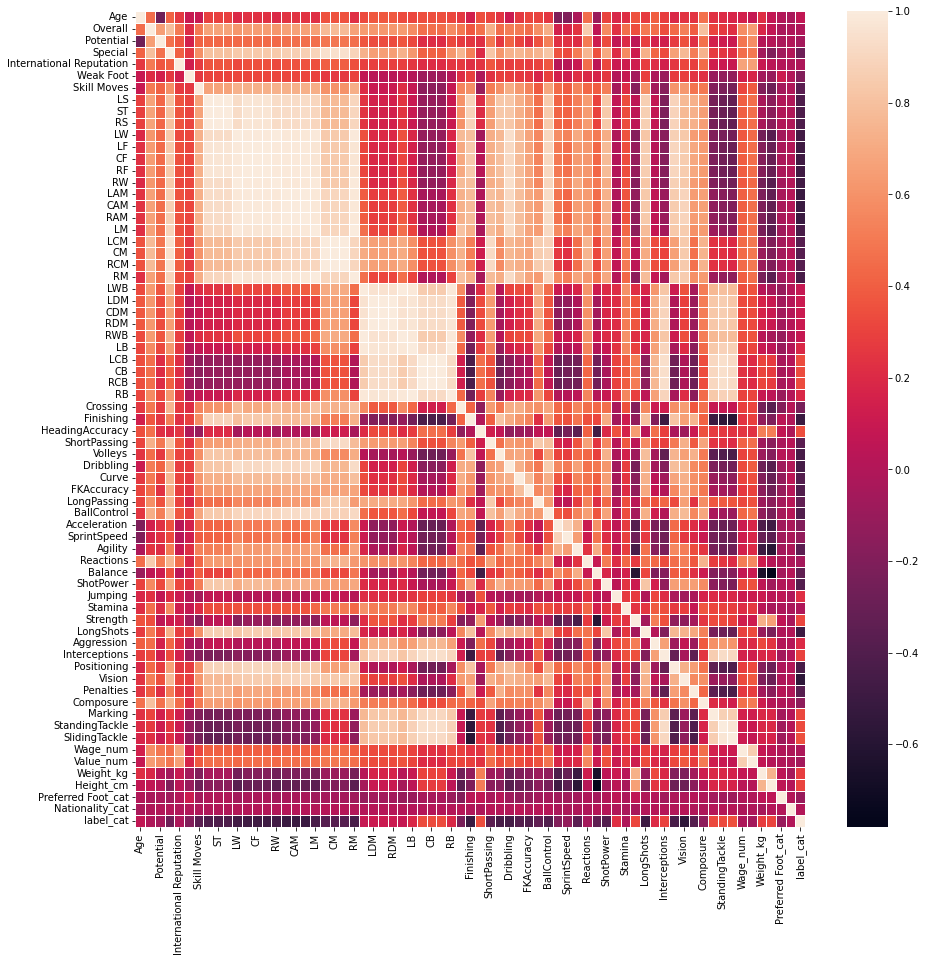

In [45]:
# np.diag(np.linalg.inv(lr.drop(['Preferred Foot_cat', 'Nationality_cat', 'label_cat'], axis=1).corr()))

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(lr.corr(), annot=False, linewidths=.5, ax=ax, cmap=sns.color_palette(color, as_cmap=True))

Man kann sehr gut erkennt, dass die Wertungen für ähnliche Positionen stark miteinander korrellieren, dies bereinigen wir nun indem wir die Dimensionen zusammenfassen. Hierfür wurde der Durchschnitt gewählt.

In [46]:
lr['Stuermer_stat'] = lr[['CF','RF', 'LF', 'ST', 'RS', 'LS', 'RW', 'LW', 'CF']].aggregate(np.mean, axis=1)
lr['Mittelfeld_stat'] = lr[['CDM', 'RCM', 'CAM', 'LCM', 'CM', 'LM', 'RAM', 'RM', 'LDM', 'RDM', 'LAM']].aggregate(np.mean, axis=1)
lr['Verteidiger_stat'] = lr[['CB', 'LB', 'RB', 'LCB', 'RWB', 'LWB', 'RCB']].aggregate(np.mean, axis=1)

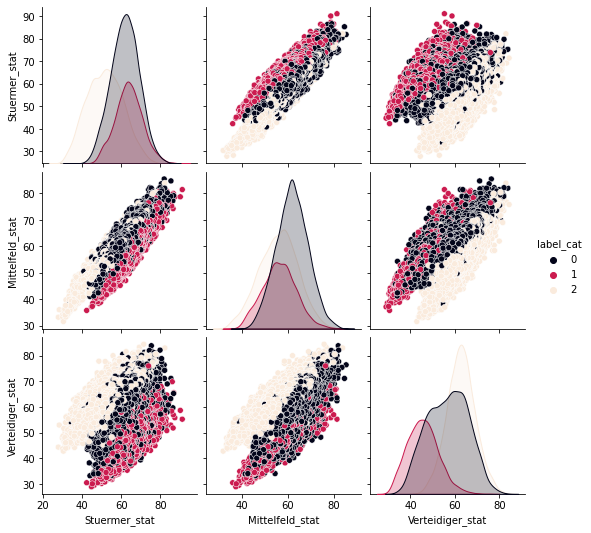

In [47]:
sns.pairplot(lr[['Stuermer_stat', 'Mittelfeld_stat', 'Verteidiger_stat', 'label_cat']], hue='label_cat', palette=color)

Hier sieht man, dass Stürmer (1) und Verteidiger (2) gut voneinander trennbar sind und die Mittelspieler (0) sich zwischen bzw. auch innerhalb der beiden anderen 'Cluster' befinden.

Danach verwerfen wir die zusammengeführten Dimensionen, um die Multikollinearität zu entfernen und nutzen für die Klassifikation unsere neu erstellten Dimensionen.

In [48]:
lr.drop(columns=['CF','RF', 'LF', 'ST', 'RS', 'LS', 'RW', 'LW', 'CF', 'CDM', 'RCM',
                'CAM', 'LCM', 'CM', 'LM', 'RAM', 'RM', 'LDM', 'RDM', 'LAM', 'CB', 'LB',
                'RB', 'LCB', 'RWB', 'LWB', 'RCB'], inplace=True)

<AxesSubplot:>

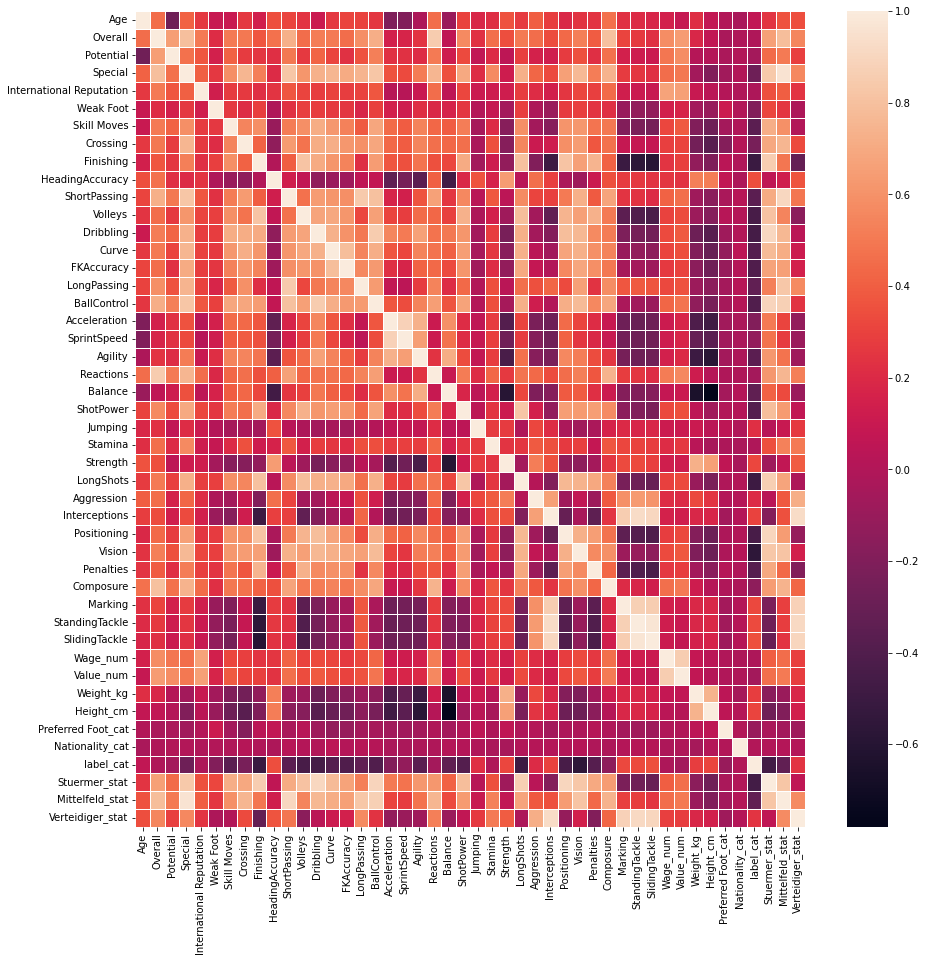

In [49]:
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(lr.corr(), annot=False, linewidths=.5, ax=ax, cmap=sns.color_palette(color, as_cmap=True))

Es ist hier gut erkennbar, dass es in Bezug auf die Multikollinearität viel besser aussieht.

**VIF-Werte > 10 werden entfernt.**

In [50]:
check = lr.drop(columns=['Preferred Foot_cat', 'Nationality_cat', 'label_cat'])
check.columns

Index(['Age', 'Overall', 'Potential', 'Special', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'Wage_num', 'Value_num', 'Weight_kg', 'Height_cm', 'Stuermer_stat',
       'Mittelfeld_stat', 'Verteidiger_stat'],
      dtype='object')

In [51]:
np.diag(np.linalg.inv(lr.drop(['Preferred Foot_cat', 'Nationality_cat', 'label_cat'], axis=1).corr()))

array([5.55182888e+00, 1.52223019e+01, 6.39380403e+00, 5.93119287e+02,
       2.16183779e+00, 1.13397608e+00, 2.55490646e+00, 3.82968650e+01,
       1.84301573e+02, 2.75231927e+01, 1.45859422e+02, 7.98349484e+00,
       1.39848500e+02, 7.83017936e+00, 7.13953921e+00, 5.75541926e+01,
       1.63437336e+02, 2.76005903e+01, 3.13442691e+01, 7.07302382e+00,
       5.57449468e+01, 6.03775015e+00, 2.49294591e+01, 4.31686048e+00,
       2.63251111e+01, 1.90233179e+01, 2.83708242e+01, 1.43242988e+01,
       2.55443336e+02, 1.48626985e+02, 9.67439609e+01, 5.47051317e+00,
       3.59674663e+00, 1.30691935e+02, 2.78182335e+02, 1.98797495e+02,
       4.17017128e+00, 5.08713579e+00, 2.98414876e+00, 3.69782612e+00,
       3.02699705e+03, 3.16733324e+03, 3.58881894e+03])

In [52]:
# aus Platzgründen wurden zwischenschritte hierbei übersprungen
np.diag(np.linalg.inv(lr.drop(['Preferred Foot_cat', 'Nationality_cat',
 'label_cat', 'Verteidiger_stat', 'Mittelfeld_stat', 'Stuermer_stat', 'Special',
 'StandingTackle', 'Overall'],
 axis=1).corr()))

array([3.6757142 , 3.83911403, 2.13753649, 1.13375061, 2.48436718,
       3.51581049, 7.11663938, 2.86249285, 6.46305847, 4.36393617,
       7.11509884, 4.4616703 , 3.47265707, 4.98317797, 7.76225908,
       5.95449929, 4.71809669, 3.84105869, 3.8257557 , 3.79767945,
       4.01198454, 1.46563454, 1.8464219 , 3.65322203, 5.94116381,
       2.54172034, 8.07726512, 5.06213757, 4.68437272, 3.00600026,
       3.50525108, 4.64906916, 8.35341399, 4.16931503, 4.88594955,
       2.9726622 , 3.6955113 ])

In [53]:
lr_2 = lr[['Verteidiger_stat', 'Mittelfeld_stat', 'Stuermer_stat', 'label_cat']].copy() # nur für spätere Variante 2

Entfernen aller Dimensionen welche zu hohe VIF-Werte hatten. (Schrittweise, mit Zwischenüberprüfung - hier verkürzt dargestellt)

In [54]:
lr.drop(['Preferred Foot_cat', 'Nationality_cat',
 'Verteidiger_stat', 'Mittelfeld_stat', 'Stuermer_stat', 'Special',
 'StandingTackle', 'Overall'],
 axis=1, inplace=True)

#### Evaluierung Variante 1 logistische Regression

In [55]:
X_lr = lr.drop("label_cat", axis=1)
y_lr = lr["label_cat"].copy()
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_lr,y_lr)

In [56]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lda, y_lr, test_size = 0.33,random_state=147)
# X_train_lr = zscore(X_train_lr) verschlechtert das Ergebnis minimal
# X_test_lr = zscore(X_test_lr)

In [57]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_lr, y_train_lr)

LogisticRegression(max_iter=1000)

In [58]:
predictions = model.predict(X_test_lr)
print(predictions)
print()
print(classification_report(y_test_lr, predictions))
print(accuracy_score(y_test_lr, predictions))

[1 0 2 ... 0 2 1]

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2186
           1       0.83      0.78      0.80      1149
           2       0.91      0.92      0.91      1913

    accuracy                           0.86      5248
   macro avg       0.85      0.85      0.85      5248
weighted avg       0.86      0.86      0.86      5248

0.8563262195121951


In [59]:
cohen_kappa_score(y_test_lr, predictions)

0.7765377994389658

### Variante 2 mit 3 Hauptmerkmalen

Wir wollten nun auch noch eine Variante mit den von uns erstellten zusammengefassten Dimensionen der Positionswertungen machen.

In [60]:
np.diag(np.linalg.inv(lr_2.drop(['label_cat'], axis=1).corr()))

array([ 6.68376224, 20.70053932, 14.0000668 ])

#### Training Variante 2

In [61]:
X_lr2 = lr_2.drop("label_cat", axis=1)
y_lr2 = lr_2["label_cat"].copy()
lda2 = LinearDiscriminantAnalysis()
X_lda2 = lda2.fit_transform(X_lr2,y_lr2)

In [62]:
X_train_lr2, X_test_lr2, y_train_lr2, y_test_lr2 = train_test_split(X_lda2, y_lr2, test_size = 0.33,random_state=147)

In [63]:
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train_lr2, y_train_lr2)

LogisticRegression(max_iter=1000)

#### Evaluierung Variante 2

In [64]:
predictions = model2.predict(X_test_lr2)
print(predictions)
print()
print(classification_report(y_test_lr2, predictions))
print(accuracy_score(y_test_lr2, predictions))

[1 0 2 ... 0 2 1]

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2186
           1       0.80      0.77      0.79      1149
           2       0.87      0.89      0.88      1913

    accuracy                           0.82      5248
   macro avg       0.82      0.82      0.82      5248
weighted avg       0.82      0.82      0.82      5248

0.8237423780487805


In [65]:
cohen_kappa_score(y_test_lr2, predictions)

0.7265246473436064

## k-NearestNeighbour classificator

Die Daten aus der ersten Variante der logistischen Regression werden wiederverwendet, wodurch diese nur noch z-normalisiert und die Hyperparameter des Modells optimiert werden müssen.

In [66]:
X_train_lr = zscore(X_train_lr)
X_test_lr = zscore(X_test_lr)

In [67]:
classifier = KNeighborsClassifier()

parameters = [{
            'n_neighbors': [10, 50, 120, 200],
            'p':[1,2],
            'metric': ['manhattan', 'chebyshev', 'euclidean', 'wminkowski','minkowski', 'seuclidean', 'mahalanobis'],
            }]

grid_search = CV(estimator= classifier,
                param_grid= parameters,
                scoring = 'accuracy',
                n_jobs = -1, # verwendet alle CPUS
                cv = 6)

grid_search.fit(X_train_rf,y_train_rf)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f}%".format(best_accuracy*100))
print("Best Parameters:", best_parameters) 

Best Accuracy: 86.27%
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 120, 'p': 1}


### Evaluierung kNN

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

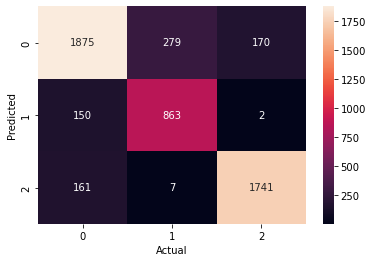

In [68]:
knn = KNeighborsClassifier(n_neighbors=120,p=1,metric='euclidean')
knn.fit(X_train_lr, y_train_lr)
pred = knn.predict(X_test_lr)
conf_matrix = confusion_matrix(pred, y_test_lr)
sns.heatmap(conf_matrix, annot=True, fmt="0", cmap=sns.color_palette(color, as_cmap=True))

**0: Mittelfeld**  
**1: Stürmer**  
**2: Verteidiger**

In [69]:
print(classification_report(y_test_lr, pred)) # ohne Optimierung 0,82 acc
print(accuracy_score(y_test_lr, pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2186
           1       0.85      0.75      0.80      1149
           2       0.91      0.91      0.91      1913

    accuracy                           0.85      5248
   macro avg       0.86      0.84      0.85      5248
weighted avg       0.85      0.85      0.85      5248

0.8534679878048781


In [70]:
cohen_kappa_score(y_test_lr, pred) # ohne Optimierung 0,73 ck

0.7712581833747018

## Support-Vector Classification

Für die SVC werden die Daten des Random Forest Models wiederverwendet und zusätzlich normalisiert.

In [71]:
X_train_svc = zscore(X_train_rf)
X_test_svc = zscore(X_test_rf)

In [72]:
classifier = SVC()

parameters = [{
            'kernel': ['linear', 'poly', 'rbf'],
            'C':[0.01,0.1,10,100],
            }]

grid_search = CV(estimator= classifier,
                param_grid= parameters,
                scoring = 'accuracy',
                n_jobs = -1, # verwendet alle CPUS
                cv = 6)

grid_search.fit(X_train_svc,y_train_rf)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f}%".format(best_accuracy*100))
print("Best Parameters:", best_parameters) 

Best Accuracy: 86.36%
Best Parameters: {'C': 10, 'kernel': 'rbf'}


In [73]:
clf = SVC(kernel='rbf', C=10) 
clf.fit(X_train_svc, y_train_rf)

SVC(C=10)

### Evaluierung SVC

In [74]:
y_pred = clf.predict(X_test_svc)

In [75]:
print(classification_report(y_test_rf, y_pred)) # ohne Optimierung 0,86 acc
print(accuracy_score(y_test_rf, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2186
           1       0.86      0.74      0.80      1149
           2       0.93      0.91      0.92      1913

    accuracy                           0.86      5248
   macro avg       0.87      0.85      0.85      5248
weighted avg       0.86      0.86      0.86      5248

0.8616615853658537


In [76]:
cohen_kappa_score(y_test_rf, y_pred) # ohne Optimierung 0,78 ck

0.7836705579168226

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

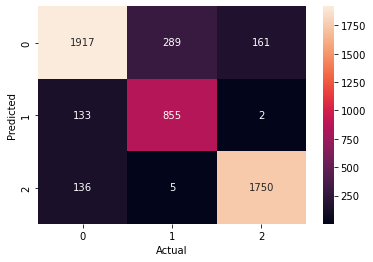

In [77]:
conf_matrix = confusion_matrix(y_pred, y_test_rf)
sns.heatmap(conf_matrix, annot=True, fmt="0", cmap=sns.color_palette(color, as_cmap=True))

**0: Mittelfeld**  
**1: Stürmer**  
**2: Verteidiger**

## Fazit

**Alle Kennzahlen im Überblick:**

|               |     Accuracy      |   Cohens Kappa    |
|---------------|-------------------|-------------------|
|Decision Tree  |       0,82        |       0,72        |
|Random Forest  |  0,86 + 0,86 oob  |       0,78        |
|Log.Reg. v1    |       0,86        |       0,77        |
|Log.Reg. v2    |       0,82        |       0,73        |
|kNN            |       0,85        |       0,77        |
|SVC            |       0.86        |       0,78        |

Laut unseren Ergebnissen wäre der SVC die beste Wahl, jedoch nehmen sich die Modelle nicht viel.
Am besten konnten die Verteidiger klassifiziert werden, was darauf schließen lässt das bei Verteidigern sich die Daten wesentlich von denen der Mittelfeldspielern und Stürmern unterscheiden.
Mittelfeldspieler und Stürmer haben also mehr Gemeinsamkeiten als die Verteidiger. (die Datensätze sind hier ähnlicher)

Weiter Ansätze (die zeitlich leider nicht mehr möglich waren) wären:
- Eliminierung der Ausreißer, falls welche gefunden werden.
- Optimierung Training/Testdaten
- Balancing des Datasets
- evtl. weitere Klassifikatoren (Voting-Classificator)